In [ ]:
from google.colab import drive
import os
drive.mount("/content/gdrive")
path = "/content/gdrive/My Drive/Colab Notebooks/"
os.chdir(path)
!ls

Mounted at /content/gdrive
'Bản sao của Facenet.ipynb'   faces.pkl         model		   y_labels.pkl
 Dataset		      id_test.pkl       nn4.small2.v1.t7
 embed_blob_faces.pkl	      id_train.pkl      nn4.small2.v2.t7
 Facenet.ipynb		      images_file.pkl   Untitled1.ipynb


install face_recognition: phát hiện vị trí các khuôn mặt trong ảnh

In [ ]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 22 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=7b2c6ca0b458125b314c68e551f96b0f723fc8a477f5895b890747f34a2af8d4
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


DATASET: là một bộ dữ liệu gồm 150 ảnh của 5 người, mỗi người 5 ảnh.


In [ ]:
!git clone https://github.com/phamdinhkhanh/FacenetDataset.git ./Dataset

fatal: destination path './Dataset' already exists and is not an empty directory.


# 3. PRETRAIN MODEL

Phương pháp 1: Sử dụng pretrain model.

Phương pháp 2: Huấn luyện lại một model mới cho dữ liệu của mình.

# 3.1) Sử dụng Pretrain model

Sử dụng pretrain model có tác dụng embedding các khuôn mặt có trong bức ảnh thành những véc tơ embedding 128 chiều. File pretrain chính là nn4.small2.v2.

Do model được huấn luyện từ pytorch nên sẽ cần các hàm để load model từ lên opencv như bên dưới.




In [ ]:
#!pip install opencv-python==3.4.2.17

In [ ]:
!pip install opencv-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 2.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Hàm load model
## Load model từ Caffe
import cv2
import os
import numpy as np


EMBEDDING_FL = os.path.join(path, "nn4.small2.v2.t7")
DATASET_PATH = os.path.join(path, "Dataset")

def _load_torch(model_path_fl):
  """
  model_path_fl: Link file chứa weigth của model
  """
  model = cv2.dnn.readNetFromTorch(model_path_fl)
  return model

In [ ]:
encoder = _load_torch(EMBEDDING_FL)

# 3.2. Convert ảnh bob

Model pretrain sẽ sử dụng input là blob images. Mục đích của blob images là để giảm nhiễu cho ảnh do chiếu sáng (illumination). Đây là bước tiền xử lý dữ liệu cần thiết khi xây dựng các model xử lý ảnh nói chung.

In [ ]:
import cv2

def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):
  """
  input:
    image: ma trận RGB của ảnh input
    out_size: kích thước ảnh blob
  return:
    imageBlob: ảnh blob
  """
  # Chuyển sang blobImage để tránh ảnh bị nhiễu sáng
  imageBlob = cv2.dnn.blobFromImage(image, 
                                    scalefactor=scaleFactor,   # Scale image
                                    size=out_size,  # Output shape
                                    mean=mean,  # Trung bình kênh theo RGB
                                    swapRB=False,  # Trường hợp ảnh là BGR thì set bằng True để chuyển qua RGB
                                    crop=False)
  return imageBlob

# 3.3. Trích suất các khuôn mặt.
Hàm _extract_bbox() có tác dụng trích xuất các vị trí khuôn mặt.

In [ ]:
#_extract_bbox() có tác dụng trích xuất các vị trí khuôn mặt.
from face_recognition import face_locations
import matplotlib.pyplot as plt

IMAGE_TEST = os.path.join(path, "Dataset/Ribisachi/0.png")

def _image_read(image_path):
  """
  input:
    image_path: link file ảnh
  return:
    image: numpy array của ảnh
  """
  image = cv2.imread(image_path, 0)
  
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  return image


image = _image_read(IMAGE_TEST)

def _extract_bbox(image, single = True):
  """
  Trích xuất ra tọa độ của face từ ảnh input
  input:
    image: ảnh input theo kênh RGB. 
    single: Lấy ra 1 face trên 1 bức ảnh nếu True hoặc nhiều faces nếu False. Mặc định True.
  return:
    bbox: Tọa độ của bbox: <start_Y>, <start_X>, <end_Y>, <end_X>
  """
  bboxs = face_locations(image)
  if len(bboxs)==0:
    return None
  if single:
    bbox = bboxs[0]
    return bbox
  else:
    return bboxs

_extract_face() sẽ trích suất ra ra ảnh RGB của face.

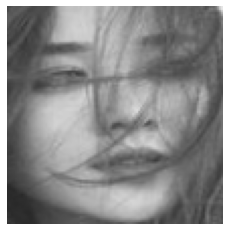

In [ ]:
def _extract_face(image, bbox, face_scale_thres = (20, 20)):
  """
  input:
    image: ma trận RGB ảnh đầu vào
    bbox: tọa độ của ảnh input
    face_scale_thres: ngưỡng kích thước (h, w) của face. Nếu nhỏ hơn ngưỡng này thì loại bỏ face
  return:
    face: ma trận RGB ảnh khuôn mặt được trích xuất từ image input.
  """
  h, w = image.shape[:2]
  try:
    (startY, startX, endY, endX) = bbox
  except:
    return None
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  face = image[minY:maxY, minX:maxX].copy()
  # extract the face ROI and grab the ROI dimensions
  (fH, fW) = face.shape[:2]

  # ensure the face width and height are sufficiently large
  if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
    return None
  else:
    return face

bbox = _extract_bbox(image)
face = _extract_face(image, bbox)
plt.axis("off")
plt.imshow(face)

 Tạo vòng lặp trích suất khuông mặt từ các bức ảnh và lưu trữ vào một pickle file. Do giả định mỗi bức ảnh chỉ bao gồm 1 người nên _extract_bbox() được thiết lập single=True.

In [ ]:
from imutils import paths
DATASET_PATH = "./Dataset"

def _model_processing(face_scale_thres = (20, 20)):
  """
  face_scale_thres: Ngưỡng (W, H) để chấp nhận một khuôn mặt.
  """
  image_links = list(paths.list_images(DATASET_PATH))
  images_file = [] 
  y_labels = []
  faces = []
  total = 0
  for image_link in image_links:
    split_img_links = image_link.split("/")
    # Lấy nhãn của ảnh
    name = split_img_links[-2] 
    # Đọc ảnh
    image = _image_read(image_link)
    (h, w) = image.shape[:2]
    # Detect vị trí các khuôn mặt trên ảnh. Gỉa định rằng mỗi bức ảnh chỉ có duy nhất 1 khuôn mặt của chủ nhân classes.
    bbox =_extract_bbox(image, single=True)
    # print(bbox_ratio)
    if bbox is not None:
      # Lấy ra face
      face = _extract_face(image, bbox, face_scale_thres = (20, 20))
      if face is not None:
        faces.append(face)
        y_labels.append(name)
        images_file.append(image_links)
        total += 1
      else:
        next
  print("Total bbox face extracted: {}".format(total))
  return faces, y_labels, images_file

faces, y_labels, images_file = _model_processing()

Total bbox face extracted: 302


Nhớ lưu dữ liệu vào các file pickle để load lên dùng lại khi cần.

In [ ]:
import pickle

def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle(faces, "./faces.pkl")
_save_pickle(y_labels, "./y_labels.pkl")
_save_pickle(images_file, "./images_file.pkl")

# 3.4. Embedding từ pretrain model
Ở bước 3.1 chúng ta đã load model encoder. Tiếp theo chúng ta sẽ sử dụng các ảnh khuôn mặt đã được trích xuất từ bước 3.2 để tạo embedding véc tơ. Đầu vào của model sẽ là các ảnh blob kích thước 96x96 nên ta sẽ convert dữ liệu về ảnh blob và sau đó truyền qua encoder.

In [ ]:
def _embedding_faces(encoder, faces):
  emb_vecs = []
  for face in faces:
    faceBlob = _blobImage(face, out_size = (96, 96), scaleFactor=1/255.0, mean=(0, 0, 0))
    # Embedding face
    encoder.setInput(faceBlob)
    vec = encoder.forward()
    emb_vecs.append(vec)
  return emb_vecs

embed_faces = _embedding_faces(encoder, faces)
# Nhớ save embed_faces vào Dataset.
_save_pickle(embed_faces, "./embed_blob_faces.pkl")

In [ ]:
embed_faces = _load_pickle("./embed_blob_faces.pkl")
y_labels = _load_pickle("./y_labels.pkl")

# 3.5. Most similarity
Để thuận tiện cho so sánh hiệu quả giữa model pretrain và model self-training chúng ta sẽ phân chia tập dữ liệu thành tập train và test với tỷ lệ 80:20 và so sánh độ chính xác chỉ trên tập test.

In [ ]:
from sklearn.model_selection import train_test_split
ids = np.arange(len(y_labels))

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(embed_faces, axis=0, out=None), y_labels, ids, test_size = 0.2, stratify = y_labels)
X_train = np.squeeze(X_train, axis = 1)
X_test = np.squeeze(X_test, axis = 1)
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(241, 128) (61, 128)
241 61


In [ ]:
_save_pickle(id_train, "./id_train.pkl")
_save_pickle(id_test, "./id_test.pkl")


Sau khi lấy được dữ liệu các khuôn mặt, chúng ta sẽ sử dụng phương pháp learning similarity  để tìm kiếm các ảnh tương đồng nhất làm nhãn cho ảnh dự báo. Theo phương pháp này chúng ta sẽ không bị phụ thuộc vào số lượng classes khi output thay đổi. Để tính toán similarity ta dùng hàm cosine_similarity của sklearn

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

# Lấy ngẫu nhiên một bức ảnh trong test
vec = X_test[5].reshape(1, -1)
# Tìm kiếm ảnh gần nhất
_most_similarity(X_train, vec, y_train)

'Nguyễn Phú Trọng'

Kiểm tra độ chính xác trên tập test

In [ ]:
# def _acc_test(test_set, y_test):
from sklearn.metrics import accuracy_score

y_preds = []
for vec in X_test:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.7213114754098361


# 4. Training triplot loss

Model pretrain đã không phát huy tác dụng. Nguyên nhân chính em nghĩ rằng pretrain model đã được training trên tập ảnh của người châu âu, trong khi khuôn mặt của người châu âu khá khác biệt so với người châu á. Do đó chúng ta sẽ cần tự huấn luyện lại model facenet cho riêng bộ dữ liệu của mình. Chúng ta kì vọng mô hình sẽ tìm ra biểu diễn cho tập ảnh trên không gian 128 chiều tốt hơn.

Khó khăn nhất của việc tự huấn luyện đó là phải tùy biến lại hàm loss function. Nên sử dụng luôn TripletSemiHardLoss của tensorflow bản 2.x.x.

# 4.1. Base network model

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None)
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 4.2. Preprocessing data
Ta thấy dữ liệu ảnh các khuôn mặt hiện tại đang không cùng shape. Do đó cần thực hiện các preprocessing image.

Chúng ta sẽ resize lại các ảnh thông qua hàm resize của opencv.

In [ ]:
faces = _load_pickle("./faces.pkl")

In [ ]:
import cv2

faceResizes = []
for face in faces:
  face_rz = cv2.resize(face, (224, 224))
  faceResizes.append(face_rz)
faceResizes = np.array(faceResizes)
X = np.stack(faceResizes, axis=0, out=None)
X.shape

(302, 224, 224, 3)

In [ ]:
# Chia tập y_test, y_train
d_train = _load_pickle("./id_train.pkl")
id_test = _load_pickle("./id_test.pkl")

X_train, X_test = X[id_train], X[id_test]

print(X_train.shape)
print(X_test.shape)

(241, 224, 224, 3)
(61, 224, 224, 3)


# 4.3. Triplet-semi-hard loss
Chúng ta sẽ sử dụng hàm triplet semi hard loss của tensorflow cho nhanh. Không phải code lại từ đầu và rất tiết kiệm thời gian. Về cách sử dụng hàm loss function xem thêm về Triplet-semi-hard loss.

Để sử dụng loss function triplet ta cần complile model như sau:

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# 4.4. Huấn luyện model

Để huấn luyện model, ta khởi tạo một tensorflow dataset với batch_size = 32 và shuffle sau mỗi 1024 steps.

In [ ]:
print(X_train.shape, len(y_train))

gen_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(1024).batch(32)
gen_train

(241, 224, 224, 3) 241


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
50/50 [==============================] - 42s 393ms/step - loss: 0.9350
Epoch 2/10
50/50 [==============================] - 20s 400ms/step - loss: 0.9449
Epoch 3/10
50/50 [==============================] - 20s 397ms/step - loss: 0.8838
Epoch 4/10
50/50 [==============================] - 20s 400ms/step - loss: 0.7640
Epoch 5/10
50/50 [==============================] - 20s 406ms/step - loss: 0.7657
Epoch 6/10
50/50 [==============================] - 20s 406ms/step - loss: 0.7496
Epoch 7/10
50/50 [==============================] - 20s 409ms/step - loss: 0.6255
Epoch 8/10
50/50 [==============================] - 21s 413ms/step - loss: 0.6848
Epoch 9/10
50/50 [==============================] - 21s 413ms/step - loss: 0.5886
Epoch 10/10
50/50 [==============================] - 21s 413ms/step - loss: 0.6188


In [ ]:
model.save("model/model_triplot.h5")

# 4.5. Accuracy on test
Sau khi huấn luyện xong mô hình ta cùng kiểm tra accuracy trên tập test

In [ ]:
X_train_vec = model.predict(X_train)
X_test_vec = model.predict(X_test)

In [ ]:
y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.6721311475409836


# 5. Phân tích lỗi
Ta sẽ biểu diễn các ảnh bị dự báo sai và xem chúng có đặc điểm gì?

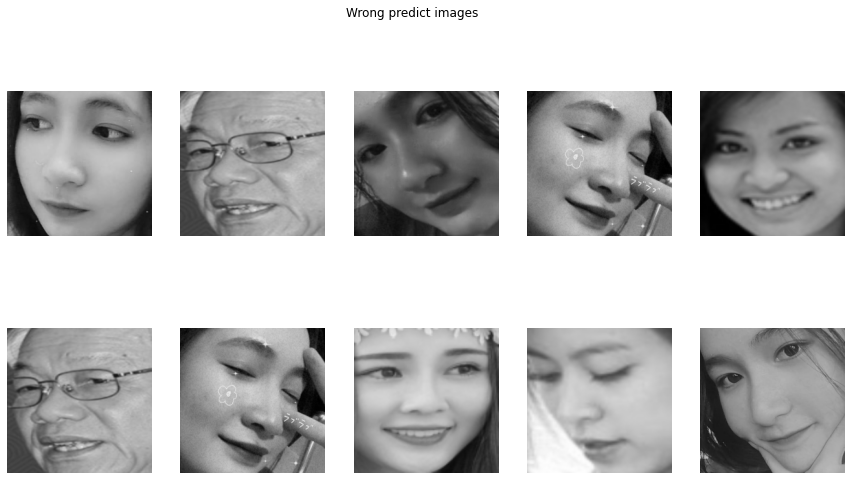

In [ ]:
dx_diff = np.flatnonzero(np.array(y_preds) != np.array(y_test))

fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Wrong predict images')

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_test[dx_diff[i + j + j*i]])
    ax[i, j].set_xlabel('Transform '+str(i+j+j*i))
    ax[i, j].axis('off')

Ta nhận thấy các bức ảnh dự đoán sai đa phần là rơi vào các trạng thái:

  +) Nhân vật đang cười.

  +) Chụp ở một góc nghiêng.

  +) Đội nón.

  +) Đeo kính

Tiếp theo ta sẽ xem các ảnh này bị dự báo sai với ảnh nào gần nhất.

In [ ]:
def _most_similarity_idx(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1][0]
  # label = [labels[idx] for idx in argmax][0]
  return argmax

# Lấy ra các bức ảnh gần nhất với các ảnh dự báo.
nearest_idx = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  argmax = _most_similarity_idx(X_train_vec, vec, y_train)
  nearest_idx.append(argmax)

# Lọc ra tiếp các ảnh bị dự báo sai.
nearest_idx = [nearest_idx[idx] for idx in dx_diff]

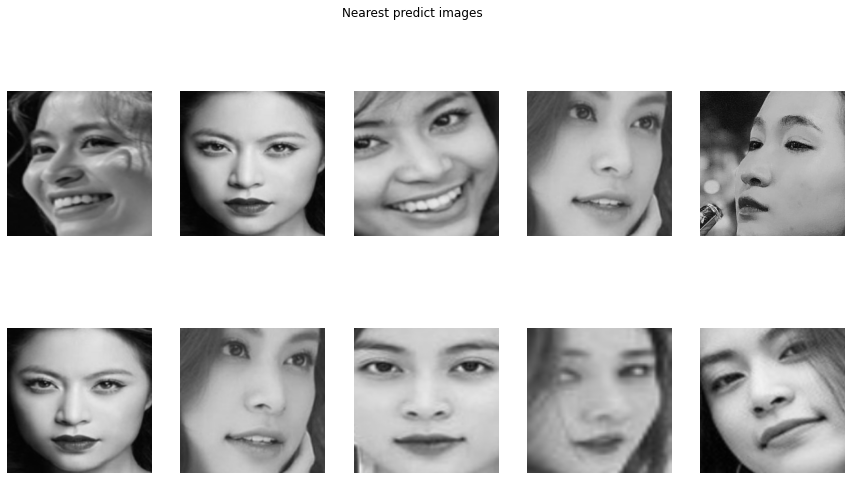

In [ ]:
fg, ax = plt.subplots(2, 5, figsize=(15, 8))
fg.suptitle('Nearest predict images')

for i in np.arange(2):
  for j in np.arange(5):
    ax[i, j].imshow(X_train[nearest_idx[i + j + j*i]])
    ax[i, j].set_xlabel('Transform '+str(i+j+j*i))
    ax[i, j].axis('off')

# Nhận xét:

Hầu hết các ảnh cười của bae yong yoon đều bị nhận nhầm thành ảnh Khanh. Cả 2 đều đeo kính và đang cười.

Hầu hết các ảnh nhận nhầm có màu da như nhau.

Như vậy để tăng cường hiệu quả nhận dạng thì:

   +) Các bức ảnh được huấn luyện nên đồng nhất về điều kiện chiếu sáng.

   +) Khuôn mặt của nhân vật cần được giữ ở trạng thái thả lỏng, không nhăn nhó.

   +) Nên thu thập đa dạng các góc nhìn của khuôn mặt. Không chỉ từ góc thẳng đứng mà còn góc nghiêng và các góc độ khác nhau. Chẳng hạn như ảnh quay tròn khuôn mặt như bên dưới.

# 6. Data Augumentation
Chúng ta thử nghiệm một số phương pháp data augumentation để xem kết quả có cải thiện không.

Tiếp theo ta sẽ khởi tạo một ImageDataGenerator để thực hiện một loạt các bến đổi cho hình ảnh. Trong đó bao gồm:

Chuẩn hóa theo phân phối chuẩn các pixels của ảnh: Trung bình các pixels bằng 0, phương sai bằng 1.

Tạo các ảnh với các góc nghiêng là 20 độ.

Dịch chuyển ảnh theo width, height.

Lật ảnh theo chiều ngang.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [ ]:
no_batch = 0
X_au = []
y_au = []
for i in np.arange(len(X_train)):
  no_img = 0
  for x in datagen.flow(np.expand_dims(X_train[i], axis = 0), batch_size = 1):
    X_au.append(x[0])
    y_au.append(y_train[i])
    no_img += 1
    if no_img == 5:
      break

6.1 Huấn luyện model


In [ ]:
import tensorflow_addons as tfa
model2 = _base_network()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [ ]:
# Điều chỉnh tăng batch_size = 64
gen_train2 = tf.data.Dataset.from_tensor_slices((X_au, y_au)).repeat().shuffle(1024).batch(64)
gen_train2

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
print(len(X_au), len(y_au))

1205 1205


In [ ]:
history = model2.fit(
    gen_train2,
    steps_per_epoch = 50,
    epochs=20)

Epoch 1/20
50/50 [==============================] - 51s 802ms/step - loss: 0.9185
Epoch 2/20
50/50 [==============================] - 41s 824ms/step - loss: 0.8594
Epoch 3/20
50/50 [==============================] - 42s 833ms/step - loss: 0.7990
Epoch 4/20
50/50 [==============================] - 42s 847ms/step - loss: 0.8123
Epoch 5/20
50/50 [==============================] - 42s 843ms/step - loss: 0.7561
Epoch 6/20
50/50 [==============================] - 42s 841ms/step - loss: 0.7661
Epoch 7/20
50/50 [==============================] - 42s 844ms/step - loss: 0.7448
Epoch 8/20
50/50 [==============================] - 42s 845ms/step - loss: 0.7016
Epoch 9/20
50/50 [==============================] - 42s 846ms/step - loss: 0.7091
Epoch 10/20
50/50 [==============================] - 42s 842ms/step - loss: 0.6966
Epoch 11/20
50/50 [==============================] - 42s 842ms/step - loss: 0.6905
Epoch 12/20
50/50 [==============================] - 42s 844ms/step - loss: 0.6729
Epoch 13/20
5

In [ ]:
model2.save("model/model_triplot_au.h5")

6.2. Accuracy trên test

Để dự báo trên tập test thì chúng ta sẽ cần phải transform ảnh trên X theo đúng như nguyên tắc tranform trên tập train.

In [ ]:
data_tf = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True
    )

data_tf.fit(X_test)

no_batch = 0
X_test_tf = []
for i in np.arange(len(X_test)):
  no_img = 0
  for x in data_tf.flow(np.expand_dims(X_test[i], axis = 0), batch_size = 1):
    X_test_tf.append(x[0])
    no_img += 1
    if no_img == 1:
      break

In [ ]:
X_train_vec = model2.predict(np.stack(X_au))
X_test_vec = model2.predict(np.stack(X_test_tf))

In [ ]:
y_preds = []
for vec in X_test_vec:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vec, vec, y_au)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.7540983606557377


7. Dự báo face trên 1 bức ảnh

Trước tiên chúng ta cần tạo một hàm normalize để tiền xử lý ảnh trước khi đưa vào dự báo mô hình.

In [ ]:
def _normalize_image(image, epsilon=0.000001):
  means = np.mean(image.reshape(-1, 3), axis=0)
  stds = np.std(image.reshape(-1, 3), axis=0)
  image_norm = image - means
  image_norm = image_norm/(stds + epsilon)
  return image_norm

In [ ]:
IMAGE_OUTPUT = "./predictions.jpg"
IMAGE_PREDICT = "./test1.jpg"

# Trích xuất bbox image 
image = _image_read(IMAGE_PREDICT)
# imageBlob = _blobImage(image)
bboxs = _extract_bbox(image, single=False)
# print(len(bboxs))
faces = []
for bbox in bboxs:
  face = _extract_face(image, bbox, face_scale_thres = (20, 20))
  # face = face.copy()
  faces.append(face)
  try:
    face_rz = cv2.resize(face, (224, 224))
    # Chuẩn hóa ảnh bằng hàm _normalize_image
    face_tf = _normalize_image(face_rz)
    face_tf = np.expand_dims(face_tf, axis = 0)
    # Embedding face
    vec = model2.predict(face_tf)
    # Tìm kiếm ảnh gần nhất
    name = _most_similarity(X_train_vec, vec, y_au)
    # Tìm kiếm các bbox
    (startY, startX, endY, endX) = bbox
    minX, maxX = min(startX, endX), max(startX, endX)
    minY, maxY = min(startY, endY), max(startY, endY)
    pred_proba=0.891
    text = "{}: {:.2f}%".format(name, pred_proba * 100)
    y = startY - 10 if startY - 10 > 10 else startY + 10
     cv2.rectangle(image, (minX, minY), (maxX, maxY), (0, 0, 255), 2)
    cv2.putText(image, text, (minX, y),
      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
  except:
      print("Not found face")
cv2.imwrite(IMAGE_OUTPUT, image)


# import matplotlib.pyplot as plt

plt.figure(figsize = (16, 8))
img = plt.imread(IMAGE_OUTPUT)
plt.imshow(img)

IndentationError: ignored